<div style="text-align: center">
    <h1 style="font-size: 42px;"><strong>EEG-based Binary Classification of Emotional Arousal: </strong></h1>
</div>
<div style="text-align: center">
    <h3 h1 style="font-size: 30px;"><strong>Exploratory Analysis and Machine Learning on <a href='https://www.eecs.qmul.ac.uk/mmv/datasets/deap/'>DEAP Dataset</a></strong></h3>
</div>

<hr>

# **Abstract**

**Background**:  
Electroencephalography (EEG) provides a non-invasive window into brain activity and is increasingly explored in affective computing. Emotional arousal — a key dimension of emotional experience — can potentially be inferred from EEG features, though its neural signatures remain subtle and difficult to extract.

**Aims**:  
This study evaluates the feasibility of classifying binary emotional arousal (high vs. low) based on EEG recordings from the [DEAP dataset](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/index.html). It was aimed to assess how well bandpower features from multiple frequency bands and scalp locations can distinguish arousal levels using both neural and classical machine learning classifiers.

**Methods:**  
EEG signals from 32 participants, each exposed to 40 music video trials (63 seconds each), were segmented into overlapping windows of 5 seconds with a 2.5-second step (50% overlap). For each window, absolute and relative bandpower was computed across four frequency bands (theta, alpha, beta, gamma) from 32 EEG channels, yielding 256 features per window. The resulting dataset contained 30,720 labeled windows (training + test). Feature selection was performed using random forest importance scores, and the top 50 features were used to train a neural network, along with logistic regression, random forest, SVM, and XGBoost classifiers. Performance was evaluated using accuracy and ROC AUC metrics.

**Results:**  
All models showed comparable, limited performance that exceeded random guessing, though the overall predictive power remained modest. Test accuracy ranged from 0.59 to 0.63, and ROC AUC from 0.64 to 0.65. The highest accuracy was achieved by the SVM classifier (63%), while the best ROC AUC score was obtained by the neural network model (65%).

**Conclusions:**  
The results suggest that EEG bandpower features carry only limited and hard-to-extract information about arousal, leading to modest model performance across classifiers. These findings highlight both the potential and limitations of EEG-based emotion recognition and suggest the need for more sophisticated feature engineering or multimodal data to improve performance in affective computing tasks.


# **Table of contents**

1. [Project overview](#1.-project-overview)  
2. [Required libraries](#2.-required-libraries)  
3. [Loading and understanding the EEG dataset](#3.-loading-and-understanding-the-eeg-dataset)  
  3.1. [Downloading DEAP data](#3.1.-downloading-deap-data)  
  3.2. [Raw EEG signal visualization and spectrogram transformation](#3.2.-raw-eeg-signal-visualization-and-spectrogram-transformation)  
4. [EEG feature extraction and target variable generation](#4.-eeg-feature-extraction-and-target-variable-generation)  
  4.1. [Aggregating data from all participants](#4.1.-aggregating-data-from-all-participants)  
  4.2. [Generating binary arousal labels](#4.2.-generating-binary-arousal-labels)  
  4.3. [Bandpower features (theta, alpha, beta, gamma) extraction](#4.3.-bandpower-features-theta-alpha-beta-gamma-extraction)  
  4.4. [Feature selection using random forest importance](#4.4.-feature-selection-using-random-forest-importance)  
  4.5. [Feature scaling](#4.5.-feature-scaling)  
5. [Neural network model](#5.-neural-network-model)  
  5.1. [Multi-layer perceptron (MLP) model architecture](#5.1.-multi-layer-perceptron-(mlp)-model-architecture)  
  5.2. [Training](#5.2.-training)  
  5.3. [Evaluation](#5.3.-evaluation)  
6. [Classical machine learning models](#6.-classical-machine-learning-models)  
  6.1. [Logistic regression](#6.1.-logistic-regression)  
  6.2. [Random forest](#6.2.-random-forest)  
  6.3. [Support vector machine](#6.3.-support-vector-machine)  
  6.4. [XGBoost](#6.4.-xgboost)  
7. [Summary and conclusions](#7.-summary-and-conclusions)

<br>  
<hr>


# **1. Project overview**

The goal of this project is to build a machine learning pipeline for **binary classification of emotional arousal** based on **electroencephalography (EEG) data**. Using the publicly available [**DEAP dataset**](https://www.eecs.qmul.ac.uk/mmv/datasets/deap/), the project aims to investigate whether brain activity, recorded from multiple scalp channels, can be used to distinguish between **low and high emotional arousal states** experienced by participants while watching music videos.

The workflow includes the following steps:

- Loading EEG data from all **32 participants**, each exposed to **40 music video sessions** (63 seconds each).
- Segmenting EEG recordings into **5-second windows** with **50% overlap** (step size: 2.5 seconds), resulting in multiple feature samples per trial.
- Extracting features based on **frequency bandpower** (theta, alpha, beta, gamma) from each of the **32 EEG channels**, producing **256 features per window** (absolute + relative power).
- Generating **binary labels** for self-assessed arousal levels per trial (high vs. low) based on median score threshold.
- Creating a final dataset of **30,720 labeled feature windows**, stratified into:
  - **24,576 training samples**
  - **6,144 test samples**
- Selecting the most informative features using **random forest feature importance** scores.
- Training a **neural network classifier** on the selected features to predict arousal state.
- Comparing neural networks with **classical ML models**: logistic regression, random forest, SVM, and XGBoost.
- Evaluating performance using **accuracy** and **ROC AUC** metrics.


# **2. Required libraries**

As a first step, we import all the essential libraries for the project:

- EEG data downloading and processing: `gdown`, `pickle`, `scipy`
- Data handling & visualization: `numpy`, `pandas`, `matplotlib`, `seaborn`
- Machine learning: `scikit-learn`, `xgboost`
- Neural network: `tensorflow.keras`


In [76]:
import gdown
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display, HTML
from scipy.signal import spectrogram
from scipy.signal import welch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from xgboost import XGBClassifier

# **3. Loading and understanding the EEG dataset**

In this section, we focus on acquiring and exploring the EEG dataset used for emotion recognition. The data originates from the [DEAP (Database for Emotion Analysis using Physiological Signals)]((https://www.eecs.qmul.ac.uk/mmv/datasets/deap/)) project, which provides preprocessed EEG signals recorded while subjects watched music videos.

We begin by downloading the EEG files from Google Drive repository using file IDs. Then, we proceed to load and inspect the structure of the data to better understand its components before applying any preprocessing or modeling steps.

## **3.1. Downloading DEAP data**

The `file_ids` dictionary maps each DEAP subject ID (e.g., `s01`, `s02`) to a corresponding Google Drive file ID.

These IDs are used for downloading the preprocessed EEG data files programmatically.


In [77]:
file_ids = {
    's01': '1IoR5kEBG86NHZcfYVGMCOdqV8S7MdKnu',
    's02': '1M_TLXeMzKYGj3hn-l2ZgI2gcog7EPAem',
    's03': '1gcLwjnr4cd4icFmFaFtGfS4y6x43xGJp',
    's04': '1WutGJ8k4F-XWJMfyeWG5CPQDPceBrffA',
    's05': '1HWuPAwiME2kFkoPXVvKhlYIs6CPCmW8D',
    's06': '1OAsfUurUf-venbRj0YcV8NhBQ0ZN37qM',
    's07': '1SHsgaX9oryuWWehW8O4D79X-RnCSIbp8',
    's08': '1mOKTBW_CHFy5TGYD__Zpi7Jua0PEanyK',
    's09': '1vSLwmutSqZ9ZijGoHDLbnOgkAnK6H-p3',
    's10': '1sv7PdRHvILkeioq2bDbvWVu89gCJeZf6',
    's11': '1zH76hJKhvFyVMbQCqqTDqEbTYLB6OW0X',
    's12': '15_DlXyym2xrSQvZPk6E8_91J3IF4ZJNc',
    's13': '1Wo68HLQ5Mzsa5faRAxfNaf-vMwAaHzFt',
    's14': '1NIHpw20IxP9FfU_m8u1u2I0opiCSt2AM',
    's15': '1cbTU1CQT6bdlWKUjpOPRSG71chXeO4Lv',
    's16': '1vssiRN62ovR0LkSjoaP1awZqk8gUGxIy',
    's17': '1gqZ-6Yd7NLg3MVpzGJ_JRN5Oyvi5oTJ7',
    's18': '1SsESUcWBPO18mF1ottOk9akWwe6VwJVe',
    's19': '1uy0myGU8s1FuQfcgr7TsuJFlP2d_MV3f',
    's20': '1qmZECybub4xncSV6jBLhs4JeapwsiMEi',
    's21': '1VHm7KI-b-tsH41_FOMk4Yl1wrNiLTh8r',
    's22': '1JYfsz4J-_w2Gl2-SDdSFuAnqSQgO2x5d',
    's23': '11KQ4VoRIwjxSNrIcsHhyq3AI89-Ip3SB',
    's24': '1DQ6azHA_wbmVsjR9oBFd8Z2ARcv1cgsU',
    's25': '1AMFnC5Tca4hOLN3J07fxGGY0_9rMRfuk',
    's26': '14lLS9H27IBp4jYYTY3B4Gv_bsD-uacFg',
    's27': '17gCClS_b1RvDoDGdV5EpMdbA8z41wNeu',
    's28': '1y_2ds8X0h8uQo9BK-H78roxaZEazzWjL',
    's29': '1jgncmfiOe8_0WJEom-Ui_ElhfJMr4V8q',
    's30': '1GZgwmczTWEeszlka9mJE3h8L1hCWvq1N',
    's31': '1c7VbfD7vuCnikhfBiOyOsjtAP95nViKu',
    's32': '1PWMYfKrr9oE4NLRezt7zZVvdezlkQyJQ'
}


Then the loop downloads the DEAP dataset files from Google Drive using the `gdown` library.

Each file is saved into the `data_preprocessed_python` directory with a filename like `s01.dat`, `s02.dat`, etc.

In [78]:
for file in file_ids:
    file_id = file_ids[file]
    gdown.download(
        f'https://drive.google.com/uc?id={file_id}', 
        f'data_preprocessed_python/{file}.dat', 
        quiet=False
    )


Downloading...
From: https://drive.google.com/uc?id=1IoR5kEBG86NHZcfYVGMCOdqV8S7MdKnu
To: c:\dev\EEG-arousal-classification\data_preprocessed_python\s01.dat
100%|██████████| 103M/103M [00:45<00:00, 2.26MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1M_TLXeMzKYGj3hn-l2ZgI2gcog7EPAem
To: c:\dev\EEG-arousal-classification\data_preprocessed_python\s02.dat
100%|██████████| 103M/103M [00:47<00:00, 2.19MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1gcLwjnr4cd4icFmFaFtGfS4y6x43xGJp
To: c:\dev\EEG-arousal-classification\data_preprocessed_python\s03.dat
100%|██████████| 103M/103M [00:38<00:00, 2.65MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1WutGJ8k4F-XWJMfyeWG5CPQDPceBrffA
To: c:\dev\EEG-arousal-classification\data_preprocessed_python\s04.dat
100%|██████████| 103M/103M [00:41<00:00, 2.48MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1HWuPAwiME2kFkoPXVvKhlYIs6CPCmW8D
To: c:\dev\EEG-arousal-classification\data_preprocessed_python\s05.dat
100%|██

Now we load EEG data for subject s01 from the DEAP dataset using Python’s `pickle` module. The `'rb'` flag opens the file in binary read mode, and `'latin1'` encoding ensures compatibility with the original format.

In [79]:
with open('data_preprocessed_python/s01.dat', 'rb') as s01:    
    subject_data = pickle.load(s01, encoding='latin1')

In [80]:
type(subject_data)

dict

In [81]:
print(subject_data.keys())

dict_keys(['labels', 'data'])


In [82]:
subject_eeg_data = subject_data['data']
subject_labels = subject_data['labels']

print(subject_eeg_data.shape)
print(subject_labels.shape)

(40, 40, 8064)
(40, 4)


The dataset is a Python dictionary containing two keys: `labels` and `data`.

`subject_data['data']` is an array of shape **40 x 40 x 8064** representing EEG and EOG data from 40 signal channels (32 EEG + 8 EOG/physiological). Each channel was sampled at 128 Hz over 60-second trials, resulting in 8064 time samples per trial. A total of 40 trials were recorded for this subject while watching 40 different videos.

`subject_data['labels']` is an array of shape **40 x 4**, where each row corresponds to a trial (one video) and contains subjective emotional ratings given by the participant. The four dimensions are:

- **valence** (*column 0*), 
- **arousal** (*column 1*), 
- **dominance** (*column 2*), and 
- **liking** (*column 3*). 

Emotional ratings were given on a **continuous scale from 1 to 9**, where higher values represent more positive valence, higher arousal, dominance, and liking. In this project, we specifically focus on the **arousal** dimension.

*(See the samples of the data below)*

In [83]:
print(subject_eeg_data[0])

[[ 9.48231681e-01  1.65333533e+00  3.01372577e+00 ... -2.82648937e+00
  -4.47722969e+00 -3.67692812e+00]
 [ 1.24706590e-01  1.39008270e+00  1.83509881e+00 ... -2.98702069e+00
  -6.28780884e+00 -4.47429041e+00]
 [-2.21651099e+00  2.29201682e+00  2.74636923e+00 ... -2.63707760e+00
  -7.40651010e+00 -6.75590441e+00]
 ...
 [ 2.30779684e+02  6.96716323e+02  1.19512165e+03 ...  1.01080949e+03
   1.28312149e+03  1.51996480e+03]
 [-1.54180981e+03 -1.61798052e+03 -1.69268642e+03 ... -1.57842691e+04
  -1.57823160e+04 -1.57808512e+04]
 [ 6.39054310e-03  6.39054310e-03  6.39054310e-03 ... -9.76081241e-02
  -9.76081241e-02 -9.76081241e-02]]


In [84]:
df_labels = pd.DataFrame(
    subject_labels, 
    columns=['Valence', 'Arousal', 'Dominance', 'Liking']
)

df_labels.head(10)

,Valence,Arousal,Dominance,Liking
0,1.29,1.40,6.90,7.83
1,0.90,1.69,7.28,8.47
2,0.42,1.46,9.00,7.08
3,4.94,6.01,6.12,8.06
4,6.96,3.92,7.19,6.05
5,8.27,3.92,7.00,8.03
6,7.44,3.73,7.08,7.04
7,7.32,2.55,6.32,5.87
8,4.04,3.29,3.62,5.99
9,1.99,4.86,2.04,7.09


## **3.2. Raw EEG signal visualization and spectrogram transformation**

To gain a better understanding of the data, we begin by visualizing the raw EEG signal recorded during the first movie presentation. The plot below shows the **first 5 seconds (640 samples)** of the recording.

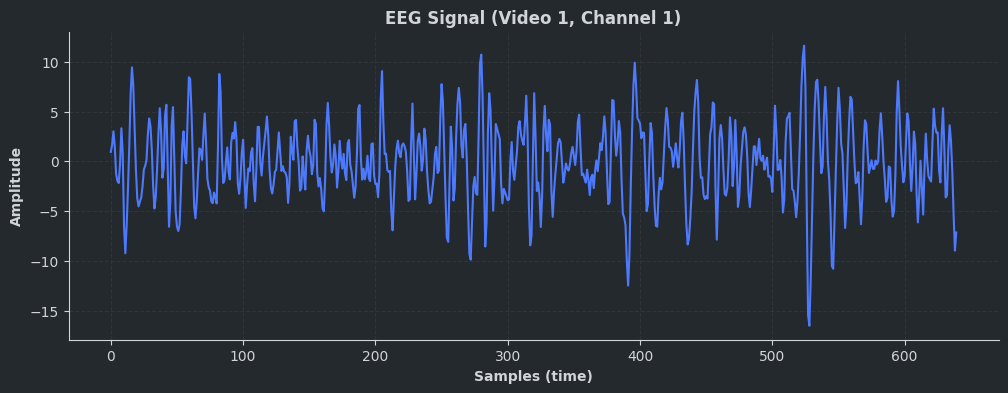

In [85]:
figure1_html = """
<p style="font-size: 16px">
    <strong>Figure 1.</strong> Raw EEG signal recorded from the first channel (Fp1) during the presentation of the first video stimulus (first 5 seconds, 640 samples).
    The signal reflects fluctuations in neural activity, already preprocessed to remove common artifacts such as eye blinks.
</p>
"""

display(HTML(figure1_html))
video_index = 0
channel_index = 0
sampling_frequency = 128
seconds = 5

sample_signal = subject_eeg_data[
    video_index, 
    channel_index, 
    0:sampling_frequency*seconds
]

background_color = '#24292e'
line_color = '#4d79fd'
text_color = '#d1d5da'
grid_color = '#313439'

plt.figure(figsize=(12, 4))
ax = plt.gca()
ax.set_facecolor('#24292e')
plt.gcf().patch.set_facecolor(background_color)

plt.plot(sample_signal, color=line_color) 
plt.title(f'EEG Signal (Video {video_index + 1}, Channel {channel_index + 1})', color=text_color, fontweight='bold')
plt.xlabel('Samples (time)', color=text_color, fontweight='bold')
plt.ylabel('Amplitude', color=text_color, fontweight='bold')

ax.tick_params(colors=text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_color(text_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid(True, linestyle='--', color=grid_color)

plt.show()


The EEG signal shown above — already preprocessed in the source data to remove common artifacts such as eye blinks — reflects neural activity patterns suitable for further transformation into **frequency-domain features**. These features will later serve as input for a **convolutional neural network (CNN)** model in our emotion classification task.

To better understand the temporal dynamics of these frequency components, using `SciPy` library we compute a **spectrogram** of the signal recorded during the first movie presentation from the first channel. Spectrograms allow us to visualize **how the power of various frequency bands evolves over time**, which is particularly important in EEG-based emotion recognition — since distinct emotional states are often linked to specific oscillatory patterns in the brain (e.g., **Alpha (8-13 Hz)** suppression during heightened arousal, or increased **Theta (4-8 Hz)** activity during calmness or introspection).

>***Note 1:***
>*Due to the use of sliding windows with overlap in spectrogram computation* `(nperseg=128, noverlap=64)`*, the resulting time axis starts slightly after 0 seconds and ends before 5 seconds. This ensures that each time window contains a complete set of samples needed for the Fourier transform.*

>***Note 2:***
>*Although the dataset has undergone basic preprocessing to remove common artifacts such as eye blinks, it is important to keep in mind that EEG signals are inherently noisy and can still contain residual artifacts or unrelated brain activity. These factors can introduce variability in the extracted >features and may impact model performance. Therefore, interpretation of the spectrogram and downstream model predictions should be made with an awareness of this inherent signal variability and noise.*


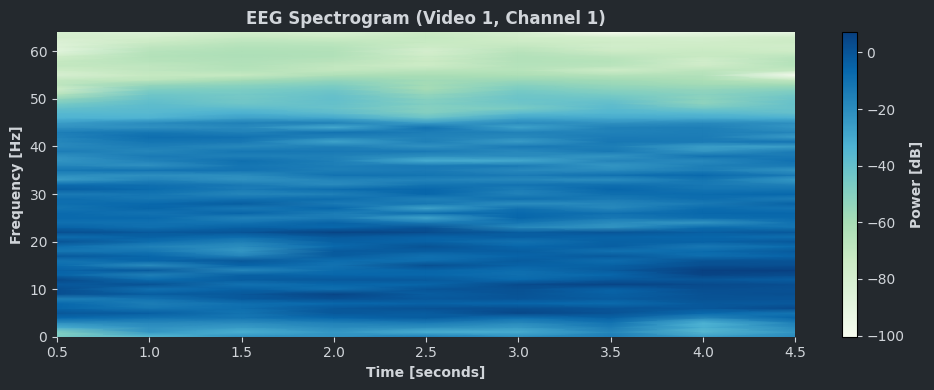

In [86]:
figure2_html = """
<p style="font-size: 16px">
    <strong>Figure 2.</strong> Spectrogram of the EEG signal from the first channel (Fp1) during the first video stimulus (first 5 seconds).
    The plot shows how signal power across frequency bands (0–60 Hz) changes over time. 
    Note that the power is expressed in decibels (dB), and the windowed Fourier transform was applied using <code>nperseg=128</code> and <code>noverlap=64</code>.
</p>
"""

display(HTML(figure2_html))

frequencies, times, spec_power = spectrogram(
    sample_signal, 
    fs=sampling_frequency, 
    nperseg=128, 
    noverlap=64
)

plt.figure(figsize=(10, 4))

ax = plt.gca()
ax.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

pcm = plt.pcolormesh(
    times, 
    frequencies, 
    10 * np.log10(spec_power), 
    shading='gouraud', 
    cmap='GnBu'
)

plt.title(f'EEG Spectrogram (Video {video_index + 1}, Channel {channel_index + 1})', color=text_color, fontweight='bold')
plt.xlabel('Time [seconds]', color=text_color, fontweight='bold')
plt.ylabel('Frequency [Hz]', color=text_color, fontweight='bold')

ax.tick_params(colors=text_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.grid(False)

cbar = plt.colorbar(pcm)
cbar.ax.yaxis.set_tick_params(color=text_color)
plt.setp(cbar.ax.yaxis.get_ticklabels(), color=text_color)
cbar.set_label('Power [dB]', color=text_color, fontweight='bold')

plt.tight_layout()
plt.show()


By transforming the raw time-series EEG data into frequency-domain representations such as this spectrogram, we gain insights into the **temporal patterns of brain oscillations**. These insights form the basis for extracting **numerical features**, which are essential for training classifiers to recognize different emotional states.

# **4. EEG feature extraction and target variable generation**

In this section, we prepare the EEG data for model training by:
- Aggregating frequency-domain features across all participants.
- Extracting the corresponding emotional ratings.
- Generating binary target labels based on arousal median score.
- Extracting theta, alpha, beta, and gamma frequency bandpowers (absolute and relative).
- Selecting top 50 relevant features based on random forest importance selection.
- Scaling selected features using *z* scores.

The resulting dataset will be used to train a machine learning model that classifies high vs. low arousal states based on neural activity.


## **4.1. Aggregating data from all participants**

In this step, we load and aggregate EEG signals and emotional ratings from all **32 participants** in the DEAP dataset.

Each participant watched **40 video clips**, and for each clip, **32 EEG channels** were recorded over a period of **63 seconds** at a sampling rate of **128 Hz**. This gives:

- **8064 samples per trial** (`63 seconds × 128 Hz`)
- **32 EEG channels per trial** (excluding peripheral channels like EOG/EMG)
- **40 trials per subject**
- **Total of 1280 trials** (`32 subjects × 40 trials`)

We only extract the first 32 EEG channels (out of 40), as the remaining 8 channels correspond to peripheral physiological signals (e.g., EOG, EMG, GSR) which are not used in this project.


In [87]:
data_path = 'data_preprocessed_python'
all_eeg_data = []
all_labels = []

for i in range(1, 33):
    file_name = f's{i:02}.dat'
    file_path = os.path.join(data_path, file_name)

    with open(file_path, 'rb') as f:
        subject_data = pickle.load(f, encoding='latin1')
        eeg_only = subject_data['data'][:32]
        all_eeg_data.append(subject_data['data'])
        all_labels.append(subject_data['labels'])

eeg_data_all = np.concatenate(all_eeg_data, axis=0)
labels_all = np.concatenate(all_labels, axis=0)

print(eeg_data_all.shape)
print(labels_all.shape)


(1280, 40, 8064)
(1280, 4)


## **4.2. Generating binary arousal labels**

To prepare the arousal ratings for binary classification, we first examine the distribution of arousal scores across all 1280 trials.


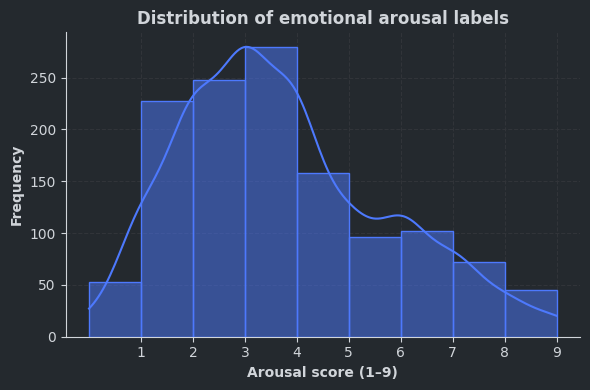

In [88]:
figure3_html = """
<p style="font-size: 16px">
    <strong>Figure 3.</strong> Histogram showing the distribution of arousal scores across all 1280 EEG trials.
    Arousal was rated on a 1–9 scale, with higher scores indicating greater emotional intensity. 
    The distribution is slightly skewed, and the median value is used as a threshold to generate binary labels 
    for classification (low vs. high arousal).
</p>
"""

display(HTML(figure3_html))

arousal_labels = labels_all[:, 1]

plt.figure(figsize=(6, 4))
ax = plt.gca()

ax.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

sns.histplot(arousal_labels, bins=9, kde=True, color=line_color, edgecolor=line_color, ax=ax, zorder=3)

ax.set_title('Distribution of emotional arousal labels', color=text_color, fontweight='bold')
ax.set_xlabel('Arousal score (1–9)', color=text_color, fontweight='bold')
ax.set_ylabel('Frequency', color=text_color, fontweight='bold')

ax.tick_params(colors=text_color)
ax.spines['bottom'].set_color(text_color)
ax.spines['left'].set_color(text_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(True, linestyle='--', color=grid_color, zorder=0)

plt.xticks(range(1, 10), color=text_color)
plt.yticks(color=text_color)

plt.tight_layout()
plt.show()


The histogram shows that the distribution is **not symmetric**, with a slight right-skew. Since the scores are on a continuous scale from 1 to 9, and there's no predefined threshold for distinguishing between "low" and "high" arousal, we adopt a **median split approach**.

Steps performed:

- Extract the **arousal dimension** (index 1) from the `labels_all` array.
- Compute the **median value** of arousal scores.
- Assign binary labels:
  - `0` for **low arousal** (score ≤ median),
  - `1` for **high arousal** (score > median).

This results in a balanced binary label distribution, which is essential for robust model training in classification tasks.

In [89]:
arousal_labels = labels_all[:, 1]
median = np.median(arousal_labels)
print(f"Median score: {median}")

Median score: 3.315


In [90]:
binary_arousal = (arousal_labels > median).astype(int)

print(np.unique(binary_arousal, return_counts=True))

(array([0, 1]), array([640, 640], dtype=int64))


## **4.3. Bandpower features (theta, alpha, beta, gamma) extraction**

In this step, we extract frequency-domain features from each EEG trial by computing power in specific brainwave bands:

- **Theta** (4–8 Hz)
- **Alpha** (8–13 Hz)
- **Beta** (13–30 Hz)
- **Gamma** (30–45 Hz)

> ***Note 1***:  
> - *We exclude the **delta band (0.5–4 Hz)** because lower frequencies are especially prone to artifacts such as sweating, head movement, and slow drifts, which may distort the signal in a way that does not reflect neural activity.*
> - *We limit the **gamma band to 45 Hz**, even though the signal contains higher frequencies (up to 60 Hz), to reduce the influence of **high-frequency muscle artifacts** (especially from facial muscles or jaw clenching), which often dominate above 45 Hz and can distort EEG interpretation.*

Each trial is segmented using a sliding window of 5 seconds (640 samples), with a 50% overlap (step size of 2.5 seconds). This ensures multiple partially overlapping segments per trial, which helps to capture temporal variability in brain activity.

For each window and each of the 32 EEG channels:
- The signal is normalized (*z*-scored).
- Power spectral density (PSD) is computed using Welch's method.
- Absolute power in each band is calculated.
- Relative power is computed by dividing band power by the total power (4–45 Hz).

Both **absolute** and **relative** power values for all four bands and all 32 channels are extracted, forming a comprehensive feature vector for each windowed segment.

These features are stored and returned in matrices `X_train` and `X_test`, ready for further processing and model training.



> ***Note 2***:  
> *To prevent data leakage, the test set is held out during preprocessing. All parameters such as scaling factors or feature importances are derived **only from the training set** and then applied to the test set.*


In [91]:
def bandpower(signal, fs, band):
    f, Pxx = welch(signal, fs=fs)
    band_mask = (f >= band[0]) & (f <= band[1])
    return np.sum(Pxx[band_mask])

bands = {
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45),
}

sampling_frequency = 128
window_size = sampling_frequency * 5
step_size = int(sampling_frequency * 2.5)

train_trials, test_trials, train_labels, test_labels = train_test_split(
    eeg_data_all, binary_arousal, test_size=0.2, stratify=binary_arousal, random_state=42
)

def extract_features(trials, labels):
    X_features = []
    y_expanded = []

    for trial, label in zip(trials, labels):
        trial_len = trial.shape[1]

        for start in range(0, trial_len - window_size + 1, step_size):
            features = []

            for ch in range(32):
                signal = trial[ch, start:start + window_size]
                signal = (signal - np.mean(signal)) / (np.std(signal) + 1e-10)

                total_power = bandpower(signal, fs=sampling_frequency, band=(4, 45))
                
                for band in bands.values():
                    bp = bandpower(signal, fs=sampling_frequency, band=band)
                    rel_bp = bp / (total_power + 1e-10)
                    
                    features.append(bp)
                    features.append(rel_bp) 

            X_features.append(features)
            y_expanded.append(label)

    return np.array(X_features), np.array(y_expanded)

X_train, y_train = extract_features(train_trials, train_labels)
X_test, y_test = extract_features(test_trials, test_labels)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (24576, 256)
y_train shape: (24576,)
X_test shape: (6144, 256)
y_test shape: (6144,)


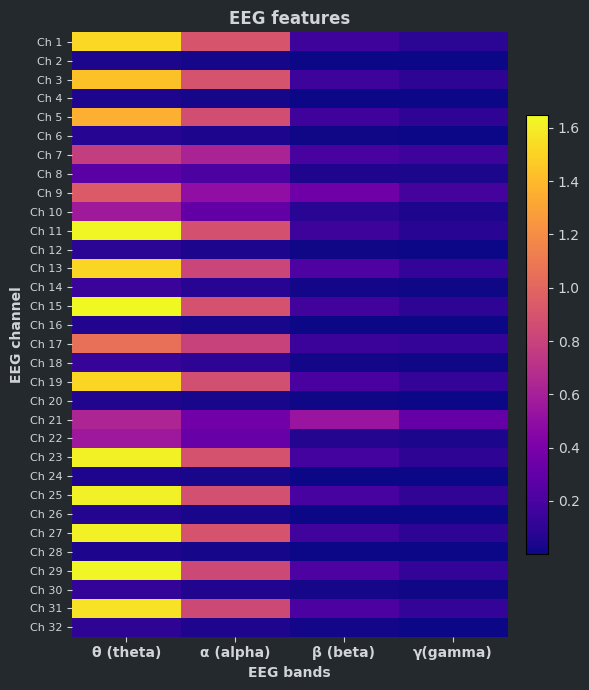

In [130]:
figure4_html = """
<p style="font-size: 16px">
    <strong>Figure 4.</strong> Heatmap showing the distribution of EEG bandpower features (θ, α, β, γ) 
    across all 32 EEG channels for a single time window. Each row corresponds to a channel, and each column 
    to a frequency band. Colors represent the absolute power, allowing for 
    comparison between channels and bands.
</p>
"""

display(HTML(figure4_html))

example = X_train[0][:128].reshape(32, 4)

fig, ax = plt.subplots(figsize=(6, 7))
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color)

im = ax.imshow(example, aspect='auto', cmap='plasma')

ax.set_title("EEG features", color=text_color, fontweight='bold')
ax.set_xlabel("EEG bands", color=text_color, fontweight='bold')
ax.set_ylabel("EEG channel", color=text_color, fontweight='bold')
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(['θ (theta)', 'α (alpha)', 'β (beta)', 'γ(gamma)'], color=text_color, fontweight='bold')
ax.set_yticks(np.arange(32))
ax.set_yticklabels([f'Ch {i+1}' for i in range(32)], color=text_color, fontsize=8)

ax.tick_params(colors=text_color)
for spine in ax.spines.values():
    spine.set_visible(False)

cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.ax.yaxis.set_tick_params(color=text_color)
plt.setp(cbar.ax.yaxis.get_ticklabels(), color=text_color)

plt.tight_layout()
plt.show()


Based on the presented example, several observations can be made:

- **Theta band** shows the highest absolute power across most channels, visible in the bright yellow coloring.
- **Alpha activity** appears consistently present, though weaker than theta, especially in central and parietal channels.
- **Beta and gamma** bands exhibit much lower power overall, consistent with the nature of resting or low-stimulation EEG recordings.
- The distribution of power across channels is not uniform — for instance, some channels (e.g., Ch 1, Ch 11, Ch 29) exhibit higher theta power than others.

These differences reflect spatial variability in brain activity and can provide meaningful input to the classification model. High power in lower frequency bands (like theta) might be associated with relaxed or low-arousal states, while reductions in alpha or increases in beta/gamma may indicate heightened arousal or attention.

## **4.4. Feature selection using random forest importance**

We use a `RandomForestClassifier` trained on the extracted EEG features to compute the importance of each feature for distinguishing between high and low arousal states.

To better understand how importance scores are distributed, we reshape and visualize them as heatmaps — separately for **absolute** and **relative** bandpower features across all EEG channels and frequency bands.

This step allows us to examine how useful each channel-band combination is for the classification task.

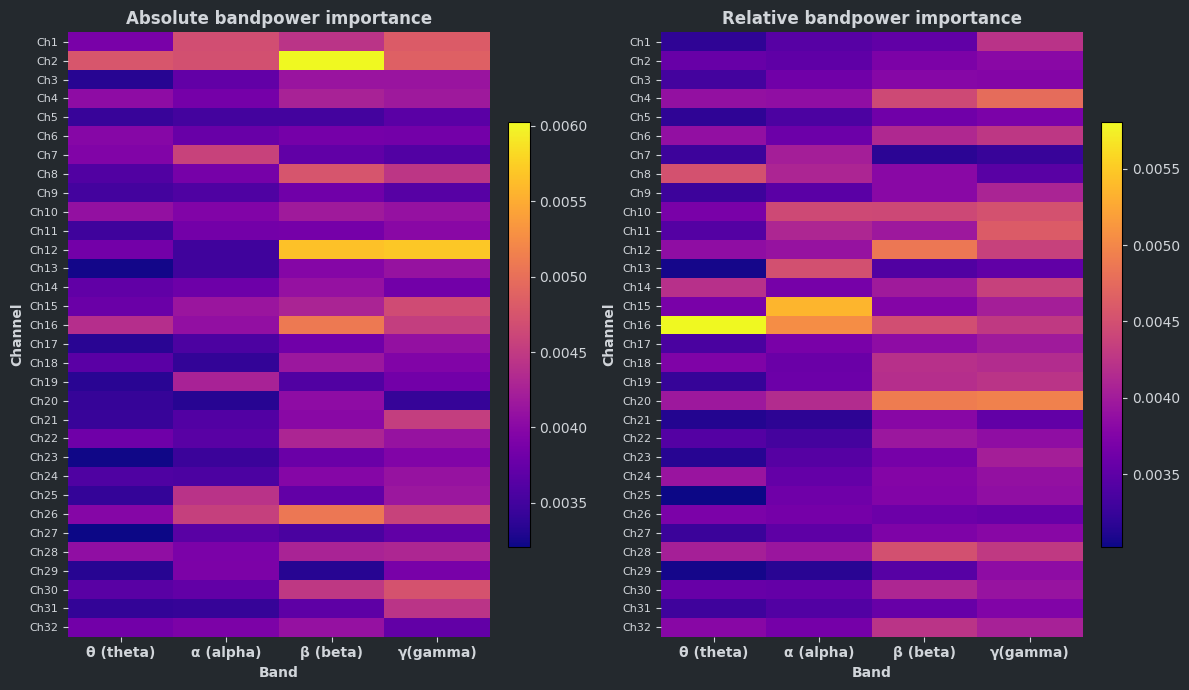

In [132]:
figure5_html = """
<p style="font-size: 16px">
    <strong>Figure 5.</strong> Heatmaps showing feature importances of EEG bandpower for binary arousal classification.
    The left panel visualizes importances of absolute bandpower features, while the right panel shows importances of relative bandpower features,
    both extracted from 32 EEG channels across four frequency bands (θ, α, β, γ).
    Brighter colors indicate higher importance values, as determined by a random forest classifier.
    Channels or bands with consistently low values are less informative, which supports further feature selection.
</p>
"""
display(HTML(figure5_html))

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_importance = rf.feature_importances_

abs_bandpower = rf_importance[:128].reshape(32, 4)
rel_bandpower = rf_importance[128:].reshape(32, 4)

bands = ['θ (theta)', 'α (alpha)', 'β (beta)', 'γ(gamma)']
channels = [f'Ch{i+1}' for i in range(32)]

fig, axes = plt.subplots(1, 2, figsize=(12, 7))
fig.patch.set_facecolor(background_color)

for ax, data, title, cmap in zip(
    axes,
    [abs_bandpower, rel_bandpower],
    ["Absolute bandpower importance", "Relative bandpower importance"],
    ['plasma', 'plasma']
):
    ax.set_facecolor(background_color)

    im = ax.imshow(data, aspect='auto', cmap=cmap)
    ax.set_title(title, color=text_color, fontweight='bold')
    ax.set_xlabel("Band", color=text_color, fontweight='bold')
    ax.set_ylabel("Channel", color=text_color, fontweight='bold')
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xticklabels(bands, color=text_color, fontweight='bold')
    ax.set_yticks(np.arange(32))
    ax.set_yticklabels(channels, color=text_color, fontsize=8)
    ax.tick_params(colors=text_color)

    for spine in ax.spines.values():
        spine.set_visible(False)

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.ax.yaxis.set_tick_params(color=text_color)
    plt.setp(cbar.ax.yaxis.get_ticklabels(), color=text_color)

plt.tight_layout()
plt.show()


As the plots above show, some channels contribute strongly in specific bands, while others appear largely uninformative across all bands. Therefore, it makes sense to reduce the feature space and retain only the most relevant ones. 

Therefore, we now sort all 256 features and select the top **50 most informative ones**. This dimensionality reduction step will help the model focus on meaningful EEG patterns while ignoring noisy or irrelevant data — improving performance and reducing the risk of overfitting.


In [94]:
df_stats = pd.DataFrame({
    'feature_index': range(X_train.shape[1]),
    'rf_importance': rf_importance
})

df_sorted_by_rf = df_stats.sort_values('rf_importance', ascending=False)


In [95]:
k = 50
top_k_features = df_sorted_by_rf['feature_index'].head(k).values

X_train_top = X_train[:, top_k_features]
X_test_df = pd.DataFrame(X_test)
X_test_top = X_test_df.iloc[:, top_k_features]


## **4.5. Feature scaling**

As a final preprocessing step, we apply feature scaling to ensure all selected features are on a comparable scale.

Using `StandardScaler` (*z*-score normalization), we transform each feature to have zero mean and unit variance, based on the training data. This is crucial for many machine learning algorithms — especially those that rely on distance metrics (e.g., SVM) or gradient-based optimization (e.g., neural networks). 


In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_top)
X_test_scaled = scaler.transform(X_test_top)


# **5. Neural network model**

In this section, we implement a neural network classifier to distinguish between low and high arousal states based on EEG-derived features.

We use a **multi-layer perceptron (MLP)** architecture — a type of feedforward neural network suitable for tabular data.  
The model is trained on the top 50 features selected by the random forest importance scores and scaled using *z*-score normalization.

The pipeline consists of:
- Defining the MLP architecture with dropout and regularization.
- Training the model with early stopping based on validation loss.
- Evaluating performance through accuracy plots and metrics.

This approach allows us to benchmark the neural network’s ability to learn non-linear mappings between EEG spectral features and emotional arousal labels.


## **5.1. Multi-layer perceptron (MLP) model architecture**

First, we design a simple MLP for binary classification of arousal labels.

The model consists of:
- An input layer accepting 50 top-ranked features.
- Two hidden layers with 128 and 64 neurons respectively, each followed by:
  - ReLU activation function,
  - L2 regularization to reduce overfitting,
  - Batch normalization to stabilize learning,
  - Dropout to improve generalization.
- A final output layer with a sigmoid activation function to produce probability scores.

The model is compiled with the Adam optimizer and binary crossentropy loss, using accuracy as the evaluation metric.


In [125]:
model = Sequential([
    Input(shape=(50,)),
    
    Dense(128, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(64, activation='relu', kernel_regularizer=l2(0.002)),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(32, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)


## **5.2. Training**

The model is trained using the training data (`X_train_scaled`, `y_train`) for up to 30 epochs with a batch size of 32.  
We use a **validation set** (`X_test_scaled`, `y_test`) to monitor model generalization during training.

Early stopping is applied with a patience of 2 epochs, meaning the training stops if validation loss does not improve for two consecutive epochs.  
This helps avoid overfitting and restores the best-performing weights from training.


In [126]:
history = model.fit(
    X_train_scaled, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)]
)


Epoch 1/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5196 - loss: 1.1661 - val_accuracy: 0.5791 - val_loss: 0.9316
Epoch 2/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5754 - loss: 0.9062 - val_accuracy: 0.5929 - val_loss: 0.8171
Epoch 3/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5979 - loss: 0.7902 - val_accuracy: 0.6045 - val_loss: 0.7453
Epoch 4/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6056 - loss: 0.7276 - val_accuracy: 0.6095 - val_loss: 0.7143
Epoch 5/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6098 - loss: 0.7025 - val_accuracy: 0.5869 - val_loss: 0.7034
Epoch 6/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6097 - loss: 0.6875 - val_accuracy: 0.6087 - val_loss: 0.6848
Epoch 7/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6047 - loss: 0.6843 - val_accuracy: 0.5959 - val_loss: 0.6922
Epoch 8/30
768/768 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6076 - loss: 0.6805 - val_accuracy: 0.

The output logs show moderate improvement in training and validation accuracy over time, with final performance stabilizing around epoch 6-8.  
However, to better understand the model’s learning dynamics — and to more clearly assess overfitting or underfitting — we will visualize the training history using accuracy and loss curves.

## **5.3. Evaluation**

Here, we plot training and validation accuracy across epochs. The curve helps identify whether the model is overfitting (training accuracy increases while validation drops) and how quickly convergence occurs.


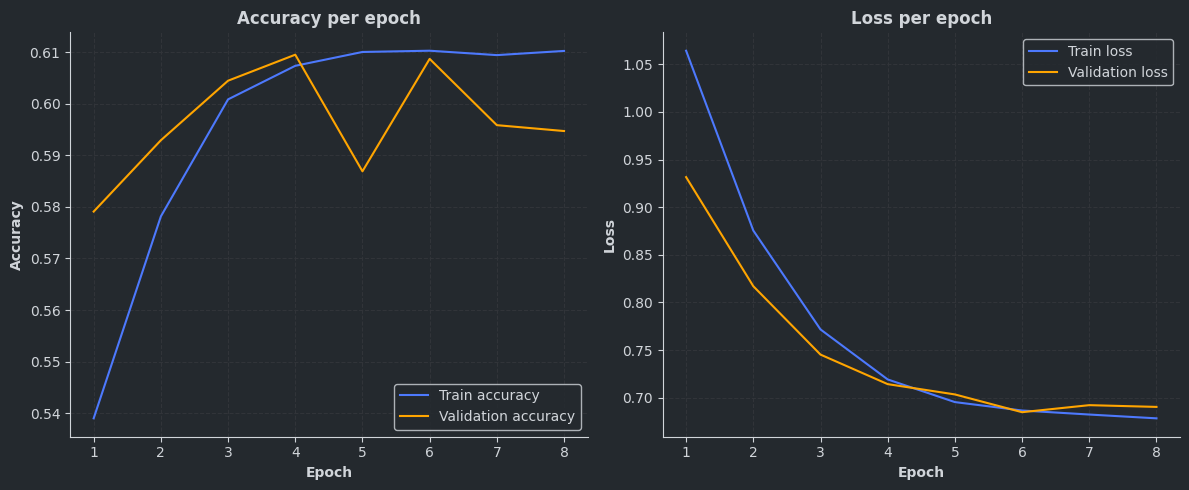

In [133]:
figure6_html = """
<p style="font-size: 16px">
    <strong>Figure 6.</strong> Training curves for the neural network model.  
    The left plot shows accuracy per epoch for both training and validation sets, while the right plot shows the corresponding loss values.  
</p>
"""
display(HTML(figure6_html))

epochs = range(1, len(history.history['accuracy']) + 1)

plt.figure(figsize=(12, 5))

ax1 = plt.subplot(1, 2, 1)
ax1.set_facecolor(background_color)
plt.gcf().patch.set_facecolor(background_color)

ax1.plot(epochs, history.history['accuracy'], label='Train accuracy', color=line_color)
ax1.plot(epochs, history.history['val_accuracy'], label='Validation accuracy', color='orange')
ax1.set_xticks(epochs)
ax1.set_title('Accuracy per epoch', color=text_color, fontweight='bold')
ax1.set_xlabel('Epoch', color=text_color, fontweight='bold')
ax1.set_ylabel('Accuracy', color=text_color, fontweight='bold')
ax1.legend(facecolor=background_color, edgecolor=text_color, labelcolor=text_color)
ax1.tick_params(colors=text_color)
ax1.spines['bottom'].set_color(text_color)
ax1.spines['left'].set_color(text_color)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(True, linestyle='--', color=grid_color)

ax2 = plt.subplot(1, 2, 2)
ax2.set_facecolor(background_color)

ax2.plot(epochs, history.history['loss'], label='Train loss', color=line_color)
ax2.plot(epochs, history.history['val_loss'], label='Validation loss', color='orange')
ax2.set_xticks(epochs)
ax2.set_title('Loss per epoch', color=text_color, fontweight='bold')
ax2.set_xlabel('Epoch', color=text_color, fontweight='bold')
ax2.set_ylabel('Loss', color=text_color, fontweight='bold')
ax2.legend(facecolor=background_color, edgecolor=text_color, labelcolor=text_color)
ax2.tick_params(colors=text_color)
ax2.spines['bottom'].set_color(text_color)
ax2.spines['left'].set_color(text_color)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.grid(True, linestyle='--', color=grid_color)

plt.tight_layout()
plt.show()


In [134]:
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype(int)


print("MLP:")
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


192/192 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MLP:
              precision    recall  f1-score   support

           0       0.61      0.60      0.60      3072
           1       0.61      0.62      0.61      3072

    accuracy                           0.61      6144
   macro avg       0.61      0.61      0.61      6144
weighted avg       0.61      0.61      0.61      6144

Accuracy: 0.61
ROC AUC: 0.65


- **Accuracy per epoch:** Both training and validation accuracy increase during the first few epochs. Starting around epoch 3, training accuracy continues to improve slightly, while validation accuracy begins the fluctuations whch are peaking around epoch 5 and then are slightly decreasing. These small oscillations in the validation curve could suggest the beginning of overfitting, although the divergence is minor. The overall accuracy remains consistent across both sets (~0.61), indicating no severe overfit, but some instability in generalization.
  
- **Loss per epoch:** Loss decreases significantly in early epochs for both training and validation. The curves converge around epoch 4–5, with minimal divergence afterwards. This indicates the model is not overfitting and learns in a stable manner.

Overall, the model demonstrates moderate learning capacity with no severe overfitting. The final evaluation yields:  

- **ROC AUC:** 0.65  
- **Precision / Recall / F1-score:** Class 1 has slightly better recall (0.62), while precision is balanced across both classes. F1-scores are nearly identical.  
- **Support:** Balanced class distribution in the test set (3072 per class).

The MLP classifier achieves performance that is **slightly better than classical models** (see below) in terms of ROC AUC, reaching 0.65. Accuracy and F1-scores remain comparable to other approaches. This result suggests that, while deep learning models can extract slightly more structure from the EEG data, the task remains inherently challenging. The neural network captures weak class-dependent patterns but does not significantly outperform simpler classifiers.

The performance exceeds random guessing, but suggests there is still room for improving feature quality or model complexity.

# **6. Classical machine learning models**

In this section, we evaluate traditional machine learning algorithms to establish a baseline for EEG-based arousal classification. The models are:

- **Logistic regression**
- **Random forest**
- **Support vector machine**
- **XGBoost**

All models are trained on the same top-ranked EEG features and evaluated using the same metrics as the above neural network model — test accuracy and ROC AUC — for consistent comparison.

## **6.1. Logistic regression**

In [101]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("Logistic Regression:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


Logistic Regression:
              precision    recall  f1-score   support

           0       0.59      0.59      0.59      3072
           1       0.59      0.59      0.59      3072

    accuracy                           0.59      6144
   macro avg       0.59      0.59      0.59      6144
weighted avg       0.59      0.59      0.59      6144

ROC AUC: 0.64


#### **Results:**

- **Accuracy:** 0.59  
- **ROC AUC:** 0.64  
- **Precision / Recall / F1-score:** Balanced across both classes (all ≈ 0.59)  
- **Support:** Equal number of examples per class in the test set  

These results indicate that logistic regression performs slightly above random guessing.  
While its predictive power is **limited**, the model is able to detect weak class-related structure in the EEG features.  
This performance is relatively **consistent with our neural network model**, suggesting that the task remains challenging regardless of model complexity.


## **6.2. Random forest**

In [102]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)
y_prob = rf.predict_proba(X_test_scaled)[:, 1]

print("Random forest:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


Random forest:
              precision    recall  f1-score   support

           0       0.60      0.62      0.61      3072
           1       0.61      0.59      0.60      3072

    accuracy                           0.61      6144
   macro avg       0.61      0.61      0.61      6144
weighted avg       0.61      0.61      0.61      6144

ROC AUC: 0.64


### **Results:**

- **Accuracy:** 0.61  
- **ROC AUC:** 0.64  
- **Precision / Recall / F1-score:** Class 0 has slightly higher precision, while Class 1 shows higher recall. F1-scores are balanced (≈ 0.60–0.61).  
- **Support:** Balanced class distribution in the test set.

These results indicate that the random forest classifier offers a small improvement over logistic regression, with slightly better accuracy and more class-sensitive predictions.  
While still limited in predictive strength, the model demonstrates the presence of weakly class-discriminative patterns in the EEG data.  
Its performance remains **comparable to our neural network**, reinforcing the consistent difficulty of the task across model types.

## **6.3. Support vector machine**

In [103]:
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)
y_prob = svm.predict_proba(X_test_scaled)[:, 1]

print("SVM:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


SVM:
              precision    recall  f1-score   support

           0       0.65      0.57      0.61      3072
           1       0.62      0.69      0.65      3072

    accuracy                           0.63      6144
   macro avg       0.63      0.63      0.63      6144
weighted avg       0.63      0.63      0.63      6144

ROC AUC: 0.64


### **Results:**

- **Accuracy:** 0.63  
- **ROC AUC:** 0.64  
- **Precision / Recall / F1-score:** Highest recall and F1-score observed for Class 1 (≈ 0.69 and 0.65 respectively), suggesting improved sensitivity to this class.  
- **Support:** Equal number of samples in both classes.

The SVM classifier achieves the **highest test accuracy (63%)** among all models, indicating a slightly stronger ability to separate the classes.  
However, the ROC AUC remains at 0.64, suggesting that probabilistic confidence is still moderate.  
Overall, SVM offers the best point prediction performance, but like the other models, does not fully resolve the challenges posed by the EEG data.


## **6.4. XGBoost**

In [104]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X_train_scaled, y_train)

y_pred = xgb.predict(X_test_scaled)
y_prob = xgb.predict_proba(X_test_scaled)[:, 1]

print("XGBoost:")
print(classification_report(y_test, y_pred))
print(f'ROC AUC: {roc_auc_score(y_test, y_pred_probs):.2f}')


c:\Users\Huawei\anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:12:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost:
              precision    recall  f1-score   support

           0       0.59      0.61      0.60      3072
           1       0.60      0.59      0.59      3072

    accuracy                           0.60      6144
   macro avg       0.60      0.60      0.60      6144
weighted avg       0.60      0.60      0.60      6144

ROC AUC: 0.64


### **Results:**

- **Accuracy:** 0.60  
- **ROC AUC:** 0.64  
- **Precision / Recall / F1-score:** Class 0 is predicted with slightly higher precision, Class 1 with better recall. F1-scores are consistent across both classes (≈ 0.60).  
- **Support:** Equal distribution of test examples across classes.

XGBoost performs similarly to the random forest classifier in both accuracy and ROC AUC, with only minimal differences in class-wise precision or recall.  
The model captures weak class-specific structure, in line with other approaches, including the neural network and logistic regression.

# **7. Summary and conclusions**

In [129]:
results = pd.DataFrame({
    'Model': ['Neural network (MLP)', 'Logistic regression', 'Random forest', 'SVM', 'XGBoost'],
    'Accuracy': [0.61, 0.59, 0.61, 0.63, 0.60],
    'ROC AUC': [0.65, 0.64, 0.64, 0.64, 0.64]
})

results

,Model,Accuracy,ROC AUC
0,Neural network (MLP),0.61,0.65
1,Logistic regression,0.59,0.64
2,Random forest,0.61,0.64
3,SVM,0.63,0.64
4,XGBoost,0.60,0.64


### **Author of the notebook**

Michał Owsiak